# Early Model Testing

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time
from sklearn.ensemble import RandomForestRegressor

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(140350, 445)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

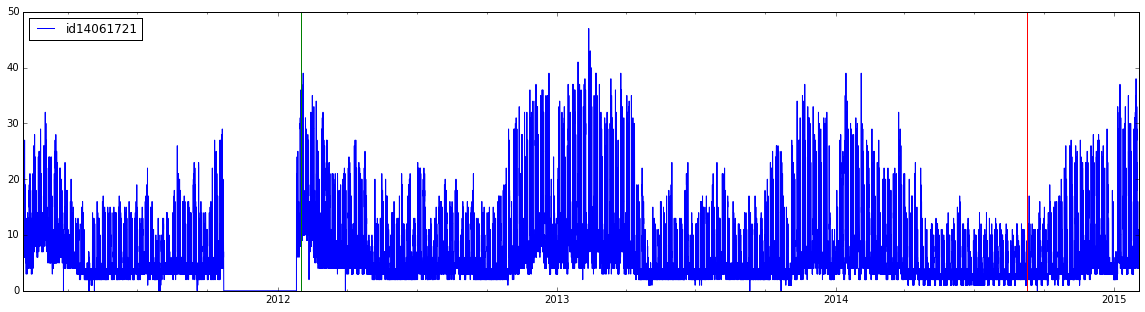

In [4]:
f = original_data[["id14061721"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

## Feature Importances

Mean importances of all sensors

In [ ]:
wetaher_current_cols =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_cols =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_cols =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

In [ ]:
feature_importances = pd.DataFrame(columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'horizon']))
feature_importances.index.name = "Feature"

sensors_list = list(data)[:30] # Sensor ids (30)

for sensor_name in sensors_list:
    print "Working with sensor: {}".format(sensor_name)
    
    # Create dataframe for specific sensor
    sensor_cols_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
    sensor_data_cols = [col for col in list(data) if col not in sensor_cols_to_drop]
    sensor_data = data[sensor_data_cols]
    
    # Replace 'sensor id' column names with 'measurement'
    sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)
    
    # Prepare columns to shift
    columnsToShift = list(sensor_data)
    shiftedColumns = ["shifted_" + col for col in columnsToShift]
    
    # Prepare datasets
    measurements_cols = [col for col in list(sensor_data) if col.startswith('measurement')]    
    all_cols = measurements_cols + wetaher_current_cols + weather_forecasted_cols + date_time_cols 

    for horizon in range (1,25):
        print "Horizon: {}h".format(horizon)
        
        sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(horizon, freq='H')
        sensor_data.dropna(inplace=True)

        training_data = sensor_data[:splitting_time]
        testing_data = sensor_data[splitting_time:]

        model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)

        X_train = training_data[all_cols].values
        y_train = training_data[["shifted_measurement"]].values.ravel()

        X_test = testing_data[all_cols].values
        y_test = testing_data[["shifted_measurement"]].values.ravel()

        start = time.time() # Start measuring time
        model.fit(X_train,y_train)
        runtime = time.time() - start # Calculate runtime

        feature_importances.loc[:,(sensor_name, horizon)] = model.feature_importances_

feature_importances.index = all_cols # Replaces index names
#feature_importances

Working with sensor: id14061671
Horizon: 1h

C:\Python27\lib\site-packages\pandas\core\frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
C:\Python27\lib\site-packages\pandas\core\frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [ ]:
output_file_name = "featureImportanceResultsAll.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances.to_csv(output_file_path)

Compute means of all sensors

In [ ]:
feature_importances_all = feature_importances.groupby(level='horizon',axis=1).mean()
feature_importances_all

In [ ]:
output_file_name = "featureImportanceResults.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances_all.to_csv(output_file_path)

In [ ]:
#import seaborn.apionly as sns
sns.set(context="paper", font="monospace")
#sns.set_style("white")

f, ax = plt.subplots(figsize=(30, 40))
sns.heatmap(feature_importances_all, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances")
plt.savefig("./figures/featureImportanceAll.pdf")
plt.savefig("./figures/featureImportanceAll.png", dpi=300)

## Top 20 Features of All Time

In [ ]:
feature_importances_all_mean = feature_importances_all.mean(axis=1)
feature_importances_all_mean.sort(ascending=False, inplace=True)
feature_importances_all_mean[:20]

In [ ]:
feature_importances_all_mean[:20][::-1].plot(kind='barh')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))